# Kaggle competition
1. Multiple online kaggle tutorials were referred while working on this lab.
2. Some contents are heavily inspired by the methods and codes Kagglers have used in their solutions.
3. A reference list is provide at the end of pdf.

### Here I am only performing an exhaustive gridsearch for several classifiers so that I can narrow down on the params

I use GridSearchCV with the same k-Fold values and the Random Seed. Fix it to 42

### Out-of-Fold Predictions for Ensembles
Another common use for out-of-fold predictions is to use them in the development of an ensemble model.

An ensemble is a machine learning model that combines the predictions from two or more models prepared on the same training dataset.

This is a very common procedure to use when working on a machine learning competition.

The out-of-fold predictions in aggregate provide information about how the model performs on each example in the training dataset when not used to train the model. This information can be used to train a model to correct or improve upon those predictions.

First, the k-fold cross-validation procedure is performed on each base model of interest, and all of the out-of-fold predictions are collected. Importantly, the same split of the training data into k-folds is performed for each model. Now we have one aggregated group of out-of-sample predictions for each model, e.g. predictions for each example in the training dataset.

* Base-Models: Models evaluated using k-fold cross-validation on the training dataset and all out-of-fold predictions are retained.
Next, a second higher-order model, called a meta-model, is trained on the predictions made by the other models. This meta-model may or may not also take the input data for each example as input when making predictions. The job of this model is to learn how to best combine and correct the predictions made by the other models using their out-of-fold predictions.

* Meta-Model: Model that takes the out-of-fold predictions made by one or more models as input and shows how to best combine and correct the predictions.
For example, we may have a two-class classification predictive modeling problem and train a decision tree and a k-nearest neighbor model as the base models. Each model predicts a 0 or 1 for each example in the training dataset via out-of-fold predictions. These predictions, along with the input data, can then form a new input to the meta-model.

* Meta-Model Input: Input portion of a given sample concatenated with the predictions made by each base model.
* Meta-Model Output: Output portion of a given sample.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import gc
import os

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline
n_jobs=-1

In [2]:
base_path = '/home/local/lambda/rishabhs/ML/data_science_lab/kagglecomp'
train = pd.read_csv("data/data-science-comp-f2020/train_final.csv")
test = pd.read_csv("data/data-science-comp-f2020/test_final.csv")

In [3]:
train.head()


,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,1,25884,1,33.63,118596,1,0,118595,125738,...,1945,118450,119184,1,121372,1,1,1,2,1
1,2,1,34346,1,10.62,118041,1,0,117902,130913,...,15385,117945,292795,1,259173,1,1,1,1,1
2,3,1,34923,1,1.77,118327,1,0,117961,124402,...,7547,118933,290919,1,118784,1,1,1,1,1
3,4,1,80926,1,30.09,118300,1,0,117961,301218,...,4933,118458,118331,1,307024,1,1,1,2,1
4,5,1,4674,1,1.77,119921,1,0,119920,302830,...,13836,142145,4673,1,128230,1,1,1,620,1


In [4]:
print(train.shape)

(16383, 26)


In [5]:
train = train.drop(['Id'],axis=1)
test = test.drop(['Id'],axis=1)

In [6]:
train.head()

,Y,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,25884,1,33.63,118596,1,0,118595,125738,1,...,1945,118450,119184,1,121372,1,1,1,2,1
1,1,34346,1,10.62,118041,1,0,117902,130913,1,...,15385,117945,292795,1,259173,1,1,1,1,1
2,1,34923,1,1.77,118327,1,0,117961,124402,1,...,7547,118933,290919,1,118784,1,1,1,1,1
3,1,80926,1,30.09,118300,1,0,117961,301218,1,...,4933,118458,118331,1,307024,1,1,1,2,1
4,1,4674,1,1.77,119921,1,0,119920,302830,1,...,13836,142145,4673,1,128230,1,1,1,620,1


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

target = "Y"
col4train = [x for x in train.columns if x not in [target, "f13"]]
y = train[target].values


In [8]:
train.head()

,Y,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,25884,1,33.63,118596,1,0,118595,125738,1,...,1945,118450,119184,1,121372,1,1,1,2,1
1,1,34346,1,10.62,118041,1,0,117902,130913,1,...,15385,117945,292795,1,259173,1,1,1,1,1
2,1,34923,1,1.77,118327,1,0,117961,124402,1,...,7547,118933,290919,1,118784,1,1,1,1,1
3,1,80926,1,30.09,118300,1,0,117961,301218,1,...,4933,118458,118331,1,307024,1,1,1,2,1
4,1,4674,1,1.77,119921,1,0,119920,302830,1,...,13836,142145,4673,1,128230,1,1,1,620,1


In [9]:
## Load all the saved models to validate
from sklearn.externals import joblib 

# Load the model from the file 
#xgbBest = joblib.load('xgbBest.pkl')  

#model4_catBoost = joblib.load('model4_catBoost.pkl')  

#stack_gen_model2 = joblib.load('stack_gen_model2.pkl')

CatBoost_best_encdata = joblib.load('CatBoost_best_encdata.pkl')

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/home/local/lambda/rishabhs/anaconda3/envs/rapids-0.16/lib/python3.8/site-packages/sklearn/externals/__init__.py)

### Target Encoding

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names ):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
    
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            self.learned_values[c] = (X_[[c,"__target__"]]
                                      .groupby(c)["__target__"].mean()
                                      .reset_index())
        self.dataset_mean = np.mean(y)
        return self
    
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)

## Target Encoding Smoothing

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncodingSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names,k, f ):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
        self.k = k #
        self.f = f #
    def smoothing_func(self, N): #
        return 1 / (1 + np.exp(-(N-self.k)/self.f))
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        self.dataset_mean = np.mean(y)
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            stats = (X_[[c,"__target__"]]
                     .groupby(c)["__target__"].
                     agg(['mean', 'size'])) 
            stats["alpha"] = self.smoothing_func(stats["size"])
            stats["__target__"] = (stats["alpha"]*stats["mean"] 
                                   + (1-stats["alpha"])*self.dataset_mean)
            stats = (stats
                     .drop([x for x in stats.columns if x not in ["__target__",c]], axis = 1)
                     .reset_index())
            self.learned_values[c] = stats
        self.dataset_mean = np.mean(y)
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)

In [12]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## Adding noise. CV inside CV.¶


In [13]:
def get_CV_target_encoding(data, y, encoder, cv = 5):
    skfTE = StratifiedKFold(n_splits=cv, random_state = 545167, shuffle = True)
    result = []
    for train_indexTE, test_indexTE in skfTE.split(data, y):
        encoder.fit(data.iloc[train_indexTE,:].reset_index(drop = True), y[train_indexTE])
        tmp =  encoder.transform(data.iloc[test_indexTE,:].reset_index(drop = True))
        tmp["index"] = test_indexTE
        result.append(tmp)
    result = pd.concat(result, ignore_index = True)
    result = result.sort_values('index').reset_index(drop = True).drop('index', axis = 1)
    return result


## Adding noise. Expanding mean

Next idea how to add noise is called expanding mean and you will now understand why.

Imagine algorithm rolling trough data and for each new row it uses all previously seen rows to calculate this new row mean. For the very first row there is no previously seen rows available so it's mean will be dataset mean. For the second row you can use first (and only first) row, because you already saw it.

This approach especially suited for streaming (that is if you have infinite stream of data coming to you).

### Advantages

Powerful, task-specific encoding
### Disadvantages

Can introduce too much noise :)


In [14]:
class TargetEncodingExpandingMean(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        self.dataset_mean = np.mean(y)
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            stats = (X_[[c,"__target__"]]
                     .groupby(c)["__target__"]
                     .agg(['mean', 'size'])) #
            stats["__target__"] = stats["mean"]
            stats = (stats
                     .drop([x for x in stats.columns if x not in ["__target__",c]], axis = 1)
                     .reset_index())
            self.learned_values[c] = stats
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
    
        #Expanding mean transform
        X_ = X[self.columns_names].copy().reset_index(drop = True)
        X_["__target__"] = y
        X_["index"] = X_.index
        X_transformed = pd.DataFrame()
        for c in self.columns_names:
            X_shuffled = X_[[c,"__target__", "index"]].copy()
            X_shuffled = X_shuffled.sample(n = len(X_shuffled),replace=False)
            X_shuffled["cnt"] = 1
            X_shuffled["cumsum"] = (X_shuffled
                                    .groupby(c,sort=False)['__target__']
                                    .apply(lambda x : x.shift().cumsum()))
            X_shuffled["cumcnt"] = (X_shuffled
                                    .groupby(c,sort=False)['cnt']
                                    .apply(lambda x : x.shift().cumsum()))
            X_shuffled["encoded"] = X_shuffled["cumsum"] / X_shuffled["cumcnt"]
            X_shuffled["encoded"] = X_shuffled["encoded"].fillna(self.dataset_mean)
            X_transformed[c] = X_shuffled.sort_values("index")["encoded"].values
        return X_transformed

But why don't we add some new features? How? Let's use feature pairs to create a new set of categorical features. Just take pair of existing features and concat them together

In [15]:
train[col4train] = train[col4train].values.astype(str)
test[col4train] = test[col4train].values.astype(str)

from itertools import combinations
new_col4train = col4train
for c1,c2 in combinations(col4train, 2):
    name = "{}_{}".format(c1,c2)
    new_col4train.append(name)
    train[name] = train[c1] + "_" + train[c2]
    test[name] = test[c1] + "_" + test[c2]


In [16]:
print(train[new_col4train].shape, test[new_col4train].shape)
train[new_col4train].head(5)

(16383, 276) (16385, 276)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f20_f21,f20_f22,f20_f23,f20_f24,f21_f22,f21_f23,f21_f24,f22_f23,f22_f24,f23_f24
0,25884.0,1.0,33.63,118596.0,1.0,0.0,118595.0,125738.0,1.0,3.0,...,1.0_1.0,1.0_1.0,1.0_2.0,1.0_1.0,1.0_1.0,1.0_2.0,1.0_1.0,1.0_2.0,1.0_1.0,2.0_1.0
1,34346.0,1.0,10.62,118041.0,1.0,0.0,117902.0,130913.0,1.0,1.0,...,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0
2,34923.0,1.0,1.77,118327.0,1.0,0.0,117961.0,124402.0,1.0,2.0,...,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0,1.0_1.0
3,80926.0,1.0,30.09,118300.0,1.0,0.0,117961.0,301218.0,1.0,0.0,...,1.0_1.0,1.0_1.0,1.0_2.0,1.0_1.0,1.0_1.0,1.0_2.0,1.0_1.0,1.0_2.0,1.0_1.0,2.0_1.0
4,4674.0,1.0,1.77,119921.0,1.0,0.0,119920.0,302830.0,1.0,0.0,...,1.0_1.0,1.0_1.0,1.0_620.0,1.0_1.0,1.0_1.0,1.0_620.0,1.0_1.0,1.0_620.0,1.0_1.0,620.0_1.0


In [17]:
train[new_col4train].apply(lambda x: len(x.unique()))


f1         5170
f2            7
f3          168
f4          162
f5            8
           ... 
f21_f23    1012
f21_f24      19
f22_f23    1003
f22_f24      19
f23_f24    1008
Length: 276, dtype: int64

And a lot of them are high-cardinality categorical features. Luckily for us we now know how to handle them. Let's use both TargetEncodingExpandingMean and TargetEncodingSmoothing with CV to create embeddings.

In [20]:
from xgboost import XGBRegressor, XGBClassifier

# Baseline model trained with X_train and y_train subset; eval is the X_val and y_val subset
# model = CatBoostClassifier(custom_metric=['TotalF1'], early_stopping_rounds=200, eval_metric='AUC', n_estimators=500)

In [21]:
cat_features=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f15', 'f16', \
              'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f1_f2', 'f1_f3', 'f1_f4', 'f1_f5', 'f1_f6', \
              'f1_f7', 'f1_f8', 'f1_f9', 'f1_f10', 'f1_f11', 'f1_f12', 'f1_f14', 'f1_f15', 'f1_f16', 'f1_f17', \
              'f1_f18', 'f1_f19', 'f1_f20', 'f1_f21', 'f1_f22', 'f1_f23', 'f1_f24', 'f2_f3', 'f2_f4', 'f2_f5', \
              'f2_f6', 'f2_f7', 'f2_f8', 'f2_f9', 'f2_f10', 'f2_f11', 'f2_f12', 'f2_f14', 'f2_f15', 'f2_f16', \
              'f2_f17', 'f2_f18', 'f2_f19', 'f2_f20', 'f2_f21', 'f2_f22', 'f2_f23', 'f2_f24', 'f3_f4', 'f3_f5', \
              'f3_f6', 'f3_f7', 'f3_f8', 'f3_f9', 'f3_f10', 'f3_f11', 'f3_f12', 'f3_f14', 'f3_f15', 'f3_f16', \
              'f3_f17', 'f3_f18', 'f3_f19', 'f3_f20', 'f3_f21', 'f3_f22', 'f3_f23', 'f3_f24', 'f4_f5', 'f4_f6', \
              'f4_f7', 'f4_f8', 'f4_f9', 'f4_f10', 'f4_f11', 'f4_f12', 'f4_f14', 'f4_f15', 'f4_f16', 'f4_f17', \
              'f4_f18', 'f4_f19', 'f4_f20', 'f4_f21', 'f4_f22', 'f4_f23', 'f4_f24', 'f5_f6', 'f5_f7', 'f5_f8', \
              'f5_f9', 'f5_f10', 'f5_f11', 'f5_f12', 'f5_f14', 'f5_f15', 'f5_f16', 'f5_f17', 'f5_f18', 'f5_f19', \
              'f5_f20', 'f5_f21', 'f5_f22', 'f5_f23', 'f5_f24', 'f6_f7', 'f6_f8', 'f6_f9', 'f6_f10', 'f6_f11', \
              'f6_f12', 'f6_f14', 'f6_f15', 'f6_f16', 'f6_f17', 'f6_f18', 'f6_f19', 'f6_f20', 'f6_f21', 'f6_f22', \
              'f6_f23', 'f6_f24', 'f7_f8', 'f7_f9', 'f7_f10', 'f7_f11', 'f7_f12', 'f7_f14', 'f7_f15', 'f7_f16', \
              'f7_f17', 'f7_f18', 'f7_f19', 'f7_f20', 'f7_f21', 'f7_f22', 'f7_f23', 'f7_f24', 'f8_f9', 'f8_f10', \
              'f8_f11', 'f8_f12', 'f8_f14', 'f8_f15', 'f8_f16', 'f8_f17', 'f8_f18', 'f8_f19', 'f8_f20', 'f8_f21', \
              'f8_f22', 'f8_f23', 'f8_f24', 'f9_f10', 'f9_f11', 'f9_f12', 'f9_f14', 'f9_f15', 'f9_f16', 'f9_f17', \
              'f9_f18', 'f9_f19', 'f9_f20', 'f9_f21', 'f9_f22', 'f9_f23', 'f9_f24', 'f10_f11', 'f10_f12', 'f10_f14', \
              'f10_f15', 'f10_f16', 'f10_f17', 'f10_f18', 'f10_f19', 'f10_f20', 'f10_f21', 'f10_f22', 'f10_f23', 'f10_f24', \
              'f11_f12', 'f11_f14', 'f11_f15', 'f11_f16', 'f11_f17', 'f11_f18', 'f11_f19', 'f11_f20', 'f11_f21', 'f11_f22', \
              'f11_f23', 'f11_f24', 'f12_f14', 'f12_f15', 'f12_f16', 'f12_f17', 'f12_f18', 'f12_f19', 'f12_f20', 'f12_f21', \
              'f12_f22', 'f12_f23', 'f12_f24', 'f14_f15', 'f14_f16', 'f14_f17', 'f14_f18', 'f14_f19', 'f14_f20', 'f14_f21', \
              'f14_f22', 'f14_f23', 'f14_f24', 'f15_f16', 'f15_f17', 'f15_f18', 'f15_f19', 'f15_f20', 'f15_f21', 'f15_f22', \
              'f15_f23', 'f15_f24', 'f16_f17', 'f16_f18', 'f16_f19', 'f16_f20', 'f16_f21', 'f16_f22', 'f16_f23', 'f16_f24', \
              'f17_f18', 'f17_f19', 'f17_f20', 'f17_f21', 'f17_f22', 'f17_f23', 'f17_f24', 'f18_f19', 'f18_f20', 'f18_f21', \
              'f18_f22', 'f18_f23', 'f18_f24', 'f19_f20', 'f19_f21', 'f19_f22', 'f19_f23', 'f19_f24', 'f20_f21', 'f20_f22', \
              'f20_f23', 'f20_f24', 'f21_f22', 'f21_f23', 'f21_f24', 'f22_f23', 'f22_f24', 'f23_f24']

In [22]:
from xgboost import XGBRegressor, XGBClassifier

model_xgBoost = XGBClassifier(
                       n_estimators=10000,
                       booster='gbtree',
                       max_depth=5,
                       gamma=0.5,
                       subsample=0.8,
                       colsample_bytree=0.6,
                       objective='binary:logistic',
                       nthread=1,
                       n_jobs=-1,
                       min_child_weight=1,
                       leaning_rate=0.05,
                       silent=0,
                       seed=42,
                       reg_alpha=0.0006,
                       #tree_method='gpu_hist',
                       #predictor = 'gpu_predictor',
                       #gpu_id=0,
                       random_state=1001)

model = model_xgBoost

In [23]:

def uniquify(df_columns):
    seen = set()

    for item in df_columns:
        fudge = 1
        newitem = item

        while newitem in seen:
            fudge += 1
            newitem = "{}_{}".format(item, fudge)

        yield newitem
        seen.add(newitem)

In [ ]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

## Backup

<BarContainer object of 24 artists>

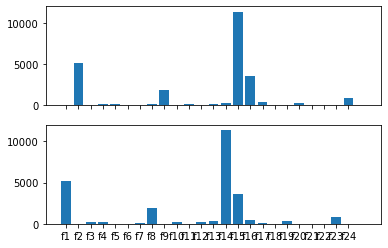

In [62]:
# Compare number of Unique Categorical labels for train and test

unique_train= pd.DataFrame([(col,train[col].nunique()) for col in train.columns], 
                           columns=['Columns', 'Unique categories'])
unique_test=pd.DataFrame([(col,test[col].nunique()) for col in test.columns],
                columns=['Columns', 'Unique categories'])
unique_train=unique_train[1:]
unique_test=unique_test[1:]

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].bar(unique_train.Columns, unique_train['Unique categories'])
ax[1].bar(unique_test.Columns, unique_test['Unique categories'])
#plt.xticks(rotation=90)

/home/local/lambda/rishabhs/anaconda3/envs/rapids-0.16/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Y', ylabel='count'>

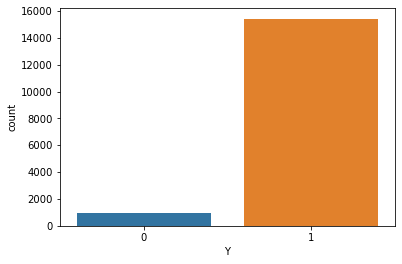

In [63]:
sns.countplot(train.Y)

## Correlations

In [64]:
# Check for duplicated rows

if (sum(train.duplicated()), sum(test.duplicated())) == (0,0):
    print('No duplicated rows')
else: 
    print('train: ',sum(train.duplicated()))
    print('test: ',sum(train.duplicated()))

No duplicated rows


In [65]:
# Check for duplicated columns                          
from itertools import combinations

for col1,col2 in combinations(train.columns, 2):
    condition1=len(train.groupby([col1,col2]).size())==len(train.groupby([col1]).size())
    condition2=len(train.groupby([col1,col2]).size())==len(train.groupby([col2]).size())
    condition3=(train[col1].nunique()==train[col2].nunique())
    if (condition1 | condition2) & condition3:
        print(col1,col2)
        print('Potential Categorical column duplication')

f13 f19
Potential Categorical column duplication


In [66]:
train.groupby(['f13', 'f19']).mean()

,,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f14,f15,f16,f17,f18,f20,f21,f22,f23,f24
f13,f19,,,,,,,,,,,,,,,,,,,,,
117880,117879,8201.386792,0.886792,37070.622642,1.042453,8.744245,116838.770440,1.039308,0.045597,117037.735849,125366.110063,...,0.276334,45289.168239,117921.644654,19721.0,1.048742,1.048742,1.040881,1.050314,374.852201,1.040881
117888,117885,8102.796526,0.962779,36908.307692,1.034739,115.603400,116779.330025,1.074442,0.069479,116375.397022,118895.178660,...,0.287161,47493.826303,117975.982630,117887.0,1.027295,1.052109,1.042184,1.039702,1087.583127,1.062035
117898,117896,7074.697368,0.986842,39311.000000,1.000000,12.133816,118601.684211,1.039474,0.013158,115509.934211,129160.250000,...,0.444761,50768.394737,118441.986842,117887.0,1.078947,1.052632,1.105263,1.052632,226907.223684,1.092105
117900,117899,8412.548387,0.919355,39978.685484,1.024194,14.631048,118152.564516,1.064516,0.032258,112783.467742,132243.411290,...,0.594241,36793.814516,117918.943548,19721.0,1.040323,1.016129,1.040323,1.032258,67.983871,1.024194
117908,117905,8248.275824,0.966499,43784.246231,1.048576,7.406131,118656.426019,1.035734,0.056393,117291.645449,144449.128978,...,0.232762,20207.386376,119778.709659,290919.0,1.045226,1.039084,1.050251,1.046901,689.810162,1.045226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247660,247659,8640.200000,1.000000,46087.600000,1.000000,9.204000,118955.000000,1.000000,0.000000,118935.400000,166596.600000,...,-0.913296,5012.400000,119613.200000,19721.0,1.200000,1.000000,1.000000,1.000000,5.200000,1.200000
254396,235351,7311.500000,1.000000,24926.500000,1.000000,1.770000,117969.000000,1.000000,0.000000,117961.000000,254394.000000,...,0.610709,16573.000000,196823.000000,254395.0,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000
258436,258434,6212.000000,1.000000,37137.000000,1.000000,1.770000,118343.000000,1.000000,0.000000,117961.000000,283557.000000,...,-4.526836,4887.000000,120126.000000,118424.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### f13 and f19 represent the same data. One of the two features can be dropped.

In [67]:
# Drop duplicated column
train.drop('f13', axis=1, inplace=True)
test.drop('f13', axis=1, inplace=True)
print('train shape: ', train.shape)
print('test shape:', test.shape)

train shape:  (16383, 25)
test shape: (16385, 24)


# Visualizing features

In [68]:
train.nunique()
#trainu = train.nunique()


Id     16383
Y          2
f1      5170
f2         7
f3       168
f4       162
f5         8
f6         9
f7       118
f8      1851
f9         7
f10      182
f11        7
f12      157
f14    11349
f15     3555
f16      432
f17       67
f18        9
f19      322
f20        7
f21        8
f22        7
f23      906
f24        7
dtype: int64

### Check for missing data
No missing data

In [69]:
#import missingno as msno 
#msno.matrix(train)


<AxesSubplot:>

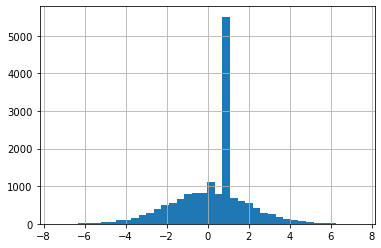

In [70]:
train['f14'].hist(bins = 40)


In [71]:
all_data = pd.concat((train.loc[:,'f1':'f24'],
                      test.loc[:,'f1':'f24']))

In [72]:
all_data.head()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,25884,1,33.63,118596,1,0,118595,125738,1,3,...,1945,118450,119184,1,121372,1,1,1,2,1
1,34346,1,10.62,118041,1,0,117902,130913,1,1,...,15385,117945,292795,1,259173,1,1,1,1,1
2,34923,1,1.77,118327,1,0,117961,124402,1,2,...,7547,118933,290919,1,118784,1,1,1,1,1
3,80926,1,30.09,118300,1,0,117961,301218,1,0,...,4933,118458,118331,1,307024,1,1,1,2,1
4,4674,1,1.77,119921,1,0,119920,302830,1,0,...,13836,142145,4673,1,128230,1,1,1,620,1


In [73]:
all_data.shape

(32768, 23)

In [74]:
#print('Train shape:', train.shape)
#print('Test shape:', test.shape)

train_labels = train['Y'].reset_index(drop=True)
train_features = train.drop(['Y'], axis=1)
test_features = test

# All features are combined here.
# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
print('All_Features shape:', all_features.shape)
all_features['f14'].head()

All_Features shape: (32768, 24)


0   -2.266430
1   -0.305612
2    2.015561
3   -3.172501
4    0.573767
Name: f14, dtype: float64

#### Categorical features are f2, f5, f6, f9, f11, f18, f20, f21, f22, f24

In [75]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cat_features = np.where(train.dtypes != np.float)[0]
print(cat_features)
all_cols = train.columns
all_cols = all_cols.drop('Y')
all_cols = all_cols.drop('Id')
cat_cols = all_cols.drop('f14')
print(list(cat_cols))


numeric = []
categorical = []
for i in train.columns:
    if train[i].dtype in cat_cols:
        if i in cat_features.tolist():
            categorical.append(i)
        else:
            numeric.append(i)

for i, feature in enumerate(list(train[categorical]), 1):
    print(i, feature)

[ 0  1  2  3  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24]
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24']


In [76]:
from sklearn.preprocessing import OneHotEncoder

all_data = pd.get_dummies(all_features)
print('Before encoding features shape:', all_features.shape)
# get_dummies converts categorical to numerical data and does one-hot encoding
# Categorical features are f2, f5, f6, f9, f11, f18, f20, f21, f22, f24
# binary encode

enc = OneHotEncoder(sparse=False, drop='first')
'''
#print(encdf_f2.head())
encdf_f2 = pd.DataFrame(enc.fit_transform(all_data[['f2']]))
encdf_f5 = pd.DataFrame(enc.fit_transform(all_data[['f5']]))
encdf_f6 = pd.DataFrame(enc.fit_transform(all_data[['f6']]))
encdf_f9 = pd.DataFrame(enc.fit_transform(all_data[['f9']]))
encdf_f11 = pd.DataFrame(enc.fit_transform(all_data[['f11']]))
encdf_f18 = pd.DataFrame(enc.fit_transform(all_data[['f18']]))
encdf_f20 = pd.DataFrame(enc.fit_transform(all_data[['f20']]))
encdf_f21 = pd.DataFrame(enc.fit_transform(all_data[['f21']]))
encdf_f22 = pd.DataFrame(enc.fit_transform(all_data[['f22']]))
encdf_f24 = pd.DataFrame(enc.fit_transform(all_data[['f24']]))
#print(encdf_f2.head())
#print(encdf_f5.head())
dfs = [encdf_f2, encdf_f5, encdf_f6, encdf_f9, encdf_f11, encdf_f18, encdf_f20, encdf_f21, encdf_f22 ,encdf_f24]
enc_dfs = pd.concat(dfs, ignore_index = True, axis=1)
print(enc_dfs.shape)
#print(enc_dfs.head())

all_data = all_data.join([enc_dfs])
'''

#print(all_data.head())

all_data = pd.DataFrame(enc.fit_transform(all_data[cat_cols]))
print('After encoding features shape:',all_data.shape)

# Remove any duplicated column names
all_data = all_data.loc[:,~all_data.columns.duplicated()]
print('After removing duplicates features shape:',all_data.shape)

#filling NA's with the mean of the column:
#all_data = all_data.fillna(all_data.mean())

print('train shape b4: ', train.shape)
print('test shape b4:', test.shape)
#creating matrices for sklearn:
X_Train = all_data[:train.shape[0]]
X_Test = all_data[train.shape[0]:]
y = train.Y

print('X_Train shape: ', X_Train.shape)
print('X_Test shape:', X_Test.shape)
print('y shape:', y.shape)


Before encoding features shape: (32768, 24)
After encoding features shape: (32768, 17512)
After removing duplicates features shape: (32768, 17512)
train shape b4:  (16383, 25)
test shape b4: (16385, 24)
X_Train shape:  (16383, 17512)
X_Test shape: (16385, 17512)
y shape: (16383,)


In [77]:
null_value_stats = X_Train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

null_value_stats = X_Test.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [78]:
X_Train.fillna(-999, inplace=True)
X_Test.fillna(-999, inplace=True)

/home/local/lambda/rishabhs/anaconda3/envs/rapids-0.16/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [79]:
X_Test.head()

,0,1,2,3,4,5,6,7,8,9,...,17502,17503,17504,17505,17506,17507,17508,17509,17510,17511
16383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
X_Train.head()
#X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,17502,17503,17504,17505,17506,17507,17508,17509,17510,17511
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# No Data preprocessing

# Playing with CVs
Play with CVs to get different n-fold partitions and see if that helps improve the rmse mean that I receive

In [81]:
from mlxtend.regressor import StackingCVRegressor
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, lasso_path
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, lasso_path, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, roc_auc_score
from datetime import datetime
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split


RANDOM_SEED = 42
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = RANDOM_SEED)


# Function to return the rmse loss
# cv = 5 means 5 folds, check if it works better with more/less number of folds
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_Train, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_Train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

def cv_auc(model, X=X_Train):
    score_auc = -cross_val_score(model, X, y, scoring="roc_auc", cv=kfolds, n_jobs = 20)
    return (score_auc)

## Some basic models


# Performing Hyperopt to optimize over hyperparameters for each model

Hyperparameters over which tuning was performed:
1. Classifier penalty
2. Number of C values to search over
3. Classifier type
4. Classifier solver


In [82]:
X_train, X_val, y_train, y_val = train_test_split(X_Train, y, train_size=0.8, random_state=RANDOM_SEED)


### Convert NumPy data to DMatrix format
With out data simulated and formatted as NumPy arrays, our next step is to convert this to a DMatrix object that XGBoost can work with. We can instantiate an object of the xgboost.DMatrix by passing in the feature matrix as the first argument followed by the label vector using the label= keyword argument. To learn more about XGBoost's support for data structures other than NumPy arrays, see the documentation for the Data Interface:

In [83]:
%%time

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_val, label=y_val)

CPU times: user 9.22 s, sys: 220 ms, total: 9.44 s
Wall time: 1.17 s


In [84]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## Best XGBoost Classifier


### Set Parameters
There are a number of parameters that can be set before XGBoost can be run.

* General parameters relate to which booster we are using to do boosting, commonly tree or linear model
* Booster parameters depend on which booster you have chosen
* Learning task parameters decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks.
For more information on the configurable parameters within the XGBoost module, see the documentation here:

In [85]:

# instantiate params
params = {}

# general params
general_params = {'silent': 1}
params.update(general_params)

# booster params
n_gpus = 1
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist'
    booster_params['n_gpus'] = n_gpus
params.update(booster_params)

# learning task params
learning_task_params = {'eval_metric': 'auc', 'objective': 'binary:logistic'}
params.update(learning_task_params)
print(params)

{'silent': 1, 'tree_method': 'gpu_hist', 'n_gpus': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}



## Train Model
Now it's time to train our model! We can use the xgb.train function and pass in the parameters, training dataset, the number of boosting iterations, and the list of items to be evaluated during training. For more information on the parameters that can be passed into xgb.train, check out the documentation:

In [86]:

# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 10

In [87]:

%%time

bst = xgb.train(params, dtrain, num_round, evallist)

[17:27:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1603299470061/work/include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[17:27:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1603299470061/work/src/learner.cc:529: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.53929	train-auc:0.56502
[1]	validation-auc:0.54717	train-auc:0.60114
[2]	validation-auc:0.55196	train-auc:0.61410
[3]	validation-auc:0.55441	train-auc:0.62367
[4]	validation-auc:0.55909	train-auc:0.63099
[5]	validation-auc:0.58487	train-auc:0.66160
[6]	valid

In [93]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
#from catboost import CatBoostClassifier, cv, Pool

#COmmented out as it takes too long to run. 
#Under construction, some things can be improved.
space = {
       hp.uniform('max_depth', 5, 12),
       hp.uniform('max_features', 0.5, 1.0),
       hp.quniform('n_estimators', 1000 , 5000, 500),
    }


def hyperparameter_tuning_xgbm(space):
    xgboost1 = XGBClassifier(
                       n_estimators=space['n_estimators'],
                       booster='gbtree',
                       max_depth=space['max_depth'],
                       max_features=space['max_features'],
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='logloss',
                       nthread=1,
                       n_jobs=16,
                       #scale_pos_weight=1,
                       silent=0,
                       seed=42,
                       reg_alpha=0.0006,
                       #tree_method='gpu_hist',
                       #predictor = 'gpu_predictor',
                       #gpu_id=0,
                       random_state=1001)

    #model.fit(X_train, y_train, cat_features=cat_features,use_best_model=True,
    #          verbose=False, eval_set=(X_val, y_val))
    #preds_class = model.predict_proba(X_val)
    #score = classification_report(y_val, preds_class, output_dict=True)['0']['f1-score']
    
    score = cross_val_score(xgboost1, X_Train, y, scoring='roc_auc', cv=skf).mean()
    print("AUC {:.3f} params {}".format(score, space))
    return score

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable

best_xgbm = fmin(fn=hyperparameter_tuning_xgbm,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
timer(start_time) # timing ends here for "start_time" variable

print(best_xgbm)


IndexError: list index out of range

In [113]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        tree_method= 'gpu_hist',
        n_gpus = 1,
        booster='gbtree',
        nthread=1,
        n_jobs=10,
        eval_metric='auc',
        **params
    )
    
    score = cross_val_score(clf, X_Train, y, scoring='roc_auc', n_jobs = 10, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 5, 12, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=35)

  0%|          | 0/35 [00:00<?, ?trial/s, best loss=?]

job exception: Unable to allocate 438. MiB for an array with shape (3277, 17512) and data type float64



  0%|          | 0/35 [00:52<?, ?trial/s, best loss=?]


MemoryError: Unable to allocate 438. MiB for an array with shape (3277, 17512) and data type float64

## Best XGBClassifier model1 
AUC 0.777 params {'colsample_bytree': 0.6234941789494903, 'num_leaves': 104.0} 
